We will do further exploratory analysis on these topics:
- Number of canceled bookings
- Canceled bookings by hotel type
- Canceled bookings by repeated and non-repeated guests
- Lead time for canceled and non-canceled bookings
- Number of cancelations by market segment
- Number of cancelations by deposit type

Then we will predict booking cancelation using several machine learning models. Here I want to focus not so much on trying as many algorithms as we can and finding the very best one, but rather on understanding the evaluation metrics for classification model and choosing a metric that matters the most in this particular case. Then we will pick one model that performs best among a few that we tried and adjust it based on our needs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
os.chdir("/Users/neera/Documents/PROJECTS/Hotel Booking")
data_cleaned = pd.read_csv("data_cleaned.csv")

### NUMBER OF CANCELED BOOKINGS

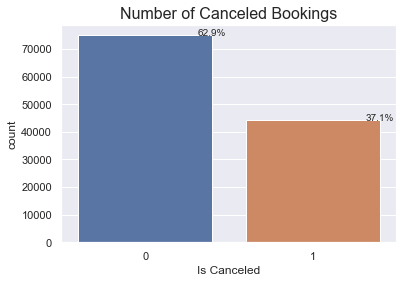

In [3]:
total = float(len(data_cleaned))
ax = sns.countplot(data_cleaned['is_canceled'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
plt.title('Number of Canceled Bookings', fontdict = {'fontsize':16})
plt.xlabel('Is Canceled')
plt.show()

There are approximately 37% canceled bookings, and the rest is not canceled.

In [4]:
total_cancelations = data_cleaned['is_canceled'].sum()
resort_cancelations = data_cleaned[data_cleaned['hotel'] == 'Resort Hotel']['is_canceled'].sum()
city_cancelations = data_cleaned[data_cleaned['hotel'] == 'City Hotel']['is_canceled'].sum()

In [5]:
relative_cancel = total_cancelations / data_cleaned.shape[0] * 100
resort_rel_cancel = resort_cancelations / data_cleaned[data_cleaned['hotel'] == 'Resort Hotel'].shape[0] * 100
city_rel_cancel = city_cancelations / data_cleaned[data_cleaned['hotel'] == 'City Hotel'].shape[0] * 100

In [6]:
print("Total bookings canceled: {:,} ({:.1f}%)".format(total_cancelations, relative_cancel))
print("Resort hotel bookings canceled: {:,} ({:.1f}%)".format(resort_cancelations, resort_rel_cancel))
print("City hotel bookings canceled: {:,} ({:.1f}%)".format(city_cancelations, city_rel_cancel))

Total bookings canceled: 44,199 (37.1%)
Resort hotel bookings canceled: 11,120 (27.8%)
City hotel bookings canceled: 33,079 (41.8%)


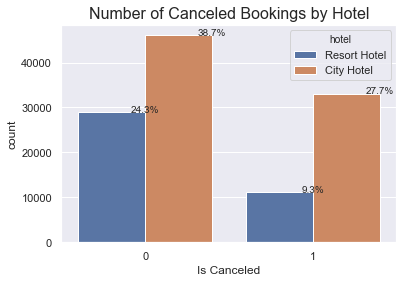

In [7]:
total = float(len(data_cleaned))
ax = sns.countplot(data_cleaned['is_canceled'], hue=data_cleaned['hotel'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
plt.title('Number of Canceled Bookings by Hotel', fontdict = {'fontsize':16})
plt.xlabel('Is Canceled')
plt.show()

The amount of canceled bookings for City Hotel is approximately 3 times more than Resort Hotel. But City Hotel also has more bookings in total and more non canceled bookings. 

### CANCELATIONS BY REPEATED GUESTS

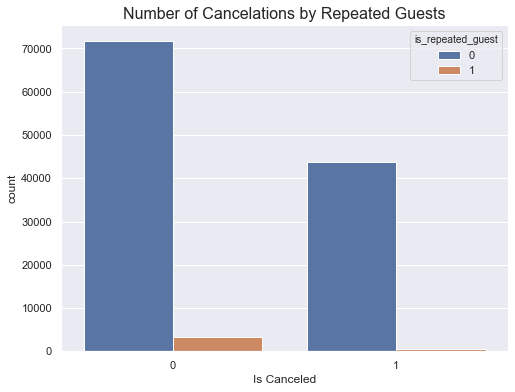

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(x = "is_canceled", hue = 'is_repeated_guest', data = data_cleaned)
plt.title('Number of Cancelations by Repeated Guests', fontdict = {'fontsize':16})
plt.xlabel('Is Canceled')
plt.show()

There is no surprise that there are less cancelations from repeated guests. But the number of repeated guests is also less than non repeated guests.

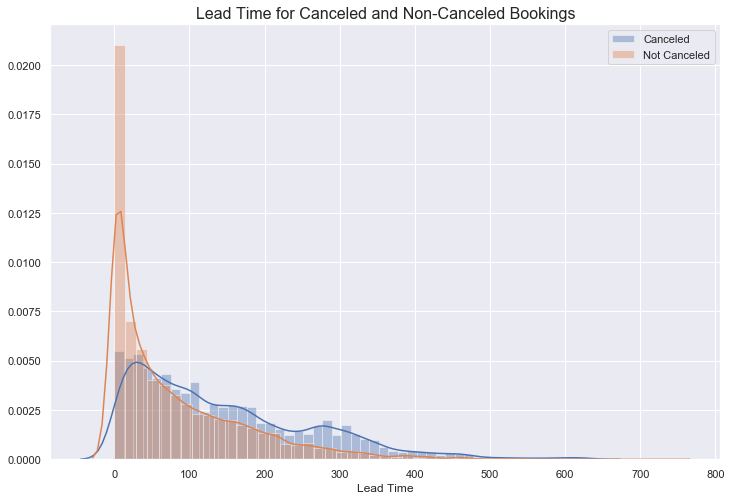

In [9]:
plt.figure(figsize=(12, 8))
sns.distplot(data_cleaned[data_cleaned['is_canceled'] == 1]['lead_time'], label='Canceled')
sns.distplot(data_cleaned[data_cleaned['is_canceled'] == 0]['lead_time'], label='Not Canceled')
plt.legend()
plt.title('Lead Time for Canceled and Non-Canceled Bookings', fontdict = {'fontsize':16})
plt.xlabel('Lead Time')
plt.show()

Lead time is the number of days that elapsed between the entering date of the booking into the PMS (Property Management System) and the arrival date.

People who did not cancel their bookings tend to have shorter lead time than people who did. 

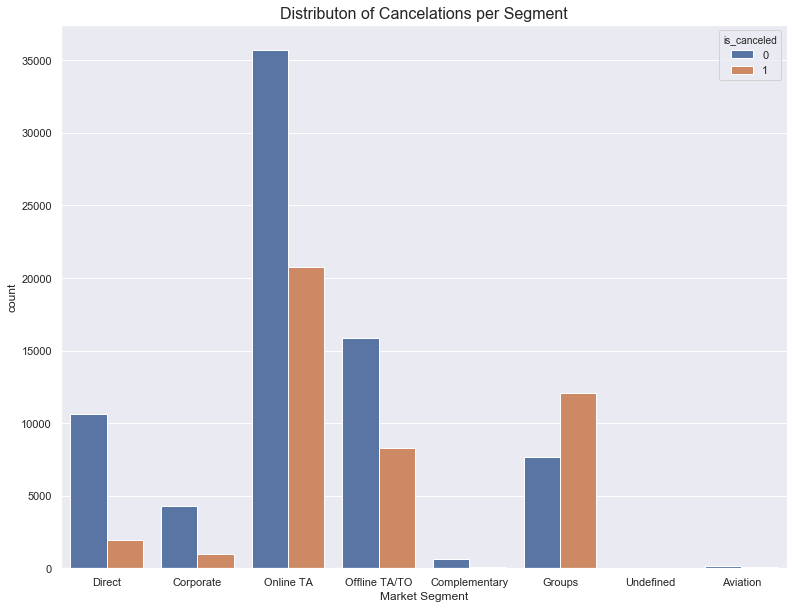

In [10]:
plt.figure(figsize = (13,10))
sns.countplot(x = 'market_segment', hue = 'is_canceled', data = data_cleaned)
plt.title('Distributon of Cancelations per Segment', fontdict = {'fontsize':16})
plt.xlabel('Market Segment')
plt.show()

People who booked through online travel agents has the highest number of cancelations. All of the categories have higher number of non canceled bookings than the canceled ones, **except** the group segment. They actually have more canceled bookings compared to non canceled bookings.

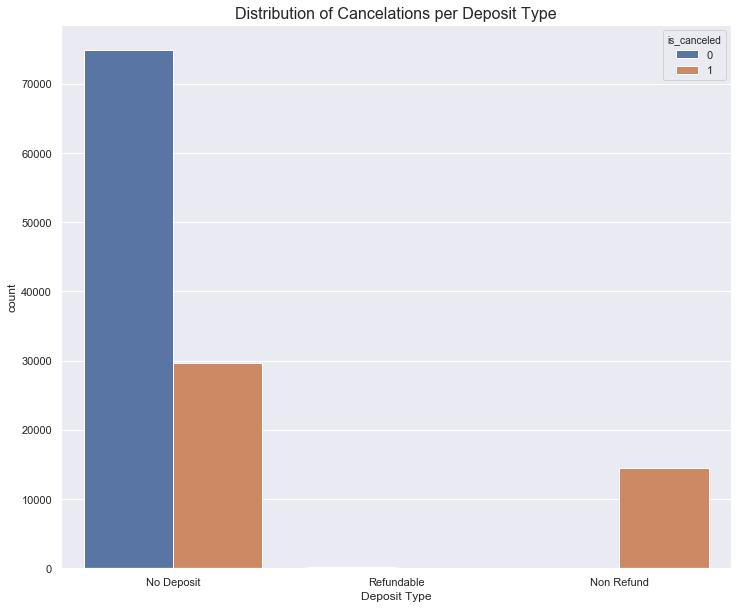

In [11]:
plt.figure(figsize = (12, 10))
sns.countplot(x = 'deposit_type', hue = 'is_canceled', data = data_cleaned)
plt.title('Distribution of Cancelations per Deposit Type', fontdict = {'fontsize':16})
plt.xlabel('Deposit Type')
plt.show()

Most guests made no deposit, followed by the guests who made non-refundable deposit, and there are less than 200 guests who made refundable deposit. Most of the guests who didn't make deposit did not cancel their bookings. But what's interesting is that most of the guests who made non-refundable deposit canceled their bookings, even though they know they won't get their money back.

In [12]:
pd.DataFrame(data_cleaned.groupby('deposit_type')['is_canceled'].value_counts())

is_canceled
deposit_type is_canceled             
No Deposit   0                  74792
             1                  29669
Non Refund   1                  14494
             0                     93
Refundable   0                    126
             1                     36

# Predicting Cancelation

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, roc_curve, precision_recall_curve, accuracy_score, matthews_corrcoef, f1_score, auc, log_loss

Which numerical features are most important?

In [14]:
cancel_corr = data_cleaned.corr()['is_canceled']
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.292876
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
booking_changes                   0.144832
previous_cancellations            0.110139
is_repeated_guest                 0.083745
company                           0.083594
adults                            0.058182
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
agent                             0.046770
adr                               0.046492
babies                            0.032569
stays_in_week_nights              0.025542
arrival_date_year                 0.016622
arrival_date_week_number          0.008315
arrival_date_day_of_month         0.005948
children                          0.004851
stays_in_weekend_nights           0.001323
Name: is_canceled, dtype: float64

From this list it is apparent that lead_time, total_of_special_requests, required_car_parking_spaces, booking_changes and previous_cancellations are the 5 most important numerical features.
However, to predict wheter or not a booking will be canceled, the number of booking changes is a possible source of leakage, because this information can change over time.
I will also not include days_in_waiting_list and arrival_date_year.

The most important feature to exclude is the 'reservation_status', because every non-canceled bookings are already checked out, and the canceled bookings' statuses are either 'Canceled' or 'No-Show'.
<br>
By keeping reservation_status in data, it is possible to achieve 100% accuracy rate because that feature is a direct way to predict cancellations, it's like cheating.

In [15]:
data_cleaned.groupby('is_canceled')['reservation_status'].value_counts()

is_canceled  reservation_status
0            Check-Out             75011
1            Canceled              42993
             No-Show                1206
Name: reservation_status, dtype: int64

**Comparing different base models**
- manually choose columns to include
- some columns are excluded to make the model more general and to prevent leakage (arrival_date_year, assigned_room_type, booking_changes, reservation_status, country, days_in_waiting_list)
- including the country would probably increase accuracy, but it may also make the model less general

In [16]:
num_features = ['lead_time','arrival_date_week_number','arrival_date_day_of_month',
                'stays_in_weekend_nights','stays_in_week_nights','adults','children',
                'babies','is_repeated_guest', 'previous_cancellations',
                'previous_bookings_not_canceled','agent','company',
                'required_car_parking_spaces', 'total_of_special_requests', 'adr']

cat_features = ['hotel','arrival_date_month','meal','market_segment',
                'distribution_channel','reserved_room_type','deposit_type','customer_type']

Separate features and target value.

In [17]:
features = num_features + cat_features
x = data_cleaned.drop(['is_canceled'], axis=1)[features]
y = data_cleaned['is_canceled']

In [18]:
x_encoded = pd.get_dummies(x, drop_first=True)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=42)

## Training the Data

#### Logistic Regression

In [20]:
logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(x_train,y_train)

LogisticRegression(solver='liblinear')

In [21]:
predictions_lr = logmodel.predict(x_test)

#### Random Forest

In [22]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [23]:
predictions_rf = rfc.predict(x_test)

#### XGBoost

In [24]:
xgboost = XGBClassifier()
xgboost.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
predictions_xgb = xgboost.predict(x_test)

## Model Evaluation

The first evaluation metric anyone would use is the **Accuracy** metric. Accuracy is the ratio of correct prediction count by total predictions made. But is Accuracy enough to evaluate a model?

Let’s talk further about our classification model. There are four distinct possibilities of predicted and actual output classes:
- If the model predicts “canceled” as “canceled”, then the case is called True Positive.
- If the model predicts “not canceled” as “canceled”, then the case is called False Positive (Type I Error).
- If the model predicts “canceled” as “not canceled”, then the case is called False Negative (Type II Error).
- If the model predicts “not canceled” as “not canceled”, then the case is called True Negative.

An easy way of showing this is with a **confusion matrix**. A confusion matrix is a n x n matrix (where n is the number of labels) used to describe the performance of a classification model. Each row in the confusion matrix represents an actual class whereas each column represents a predicted class.

**EXAMPLE:** Shown below is the confusion matrix from our Logistic Regression model above.

In [26]:
pd.DataFrame(data=confusion_matrix(y_test, predictions_lr), columns =['P No', 'P Yes'], index = ['A No', 'A Yes'])

,P No,P Yes
A No,14038,920
A Yes,3649,5235


**Accuracy:**

In [27]:
(5235 + 14038)/(14038 + 920 + 3649 + 5235)

0.808363392332858

In [28]:
accuracy_score(y_test, predictions_lr)

0.808363392332858

Accuracy simply measures how often the classifier correctly predicts. We can define accuracy as the ratio of the number of correct predictions and the total number of predictions.

So the Accuracy metric does not represent any information about False Positive, False Negative, etc. So there is substantial information loss as these may help us evaluate & upgrade our model.

Accuracy is useful when the target class is well balanced but is not a good choice for the unbalanced classes. In reality, data is often imbalanced, for example: spam email, credit card fraud, medical diagnosis, and of course, our hotel booking cancelation data. Hence, if we want to do a better model evaluation and have a full picture of the model evaluation, other metrics such as recall and precision should also be considered.

**Recall (Sensitivity)** — Recall explains how many of the actual positive cases we were able to predict correctly with our model (the ratio of True Positives count to the total Actual Positive count). 

RECALL = True Positive / (True Positive + False Negative)

It is a useful metric in cases **where False Negative is of higher concern than False Positive**. It is important for example in medical cases where it doesn’t matter whether we raise a false alarm but the actual positive cases should not go undetected.

**Precision** —Precision explains how many of the correctly predicted cases actually turned out to be positive. 

PRECISION = True Positive / (True Positive + False Positive)

Precision is useful in the cases **where False Positive is of higher concern than False Negative**.

**F1 Score** — It gives a combined idea about Precision and Recall metrics. It is maximum when Precision is equal to Recall.
F1 Score is the harmonic mean of precision and recall.

**AUC-ROC Curve** — ROC stands for Receiver Operating Characteristics. It is a graph of True Positive Rate (TPR) on the y-axis vs False Positive Rate (FPR) on the x-axis for a number of different candidate threshold values between 0.0 and 1.0.
1. TPR means recall or sensitivity.
2. FPR is the ratio of negative classes inaccurately being classified as positive. The false positive rate is also referred to as the inverted specificity where specificity is the total number of true negatives divided by the sum of the number of true negatives and false positives.

True Positive Rate = TP/(TP+FN)
<br>
False Positive Rate = FP/(FP+TN) 
<br>
Specificity = TN/(FP+TN)
<br>
False Positive Rate = 1 - Specificity

- Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
- Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

A model with perfect skill is represented at a point (0,1). A model with perfect skill is represented by a line that travels from the bottom left of the plot to the top left and then across the top to the top right.

**Precision-Recall Curve** - A precision-recall curve is a plot of the precision (y-axis) and the recall (x-axis) for different thresholds, much like the ROC curve. 

PRECISION = True Positive / (True Positive + False Positive)
<br>
RECALL = True Positive / (True Positive + False Negative)

Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1). 
The reason for this is that typically the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives.

Key to the calculation of precision and recall is that the calculations do not make use of the true negatives. It is only concerned with the correct prediction of the minority class, class 1.

A model with perfect skill is depicted as a point at (1,1). 

**So, in this case, which one matters more, the False Positive or False Negative?**

In my opinion, I think the answer would be False Positive (the model predicts non-canceled as canceled). Because then customers would come to the hotel and find that their room is not ready yet, or worse, had been given to someone else. This could results in bad reviews, generating negative word of mouth, especially in this era of social media. The damage would be more severe than a few empty hotel rooms as a result of False Negative prediction. So I think in this case, Precision would be a more useful metric than Recall.

Let's compare the evaluation metrics of the 3 models.

In [29]:
print(classification_report(y_test, predictions_lr))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86     14958
           1       0.85      0.59      0.70      8884

    accuracy                           0.81     23842
   macro avg       0.82      0.76      0.78     23842
weighted avg       0.81      0.81      0.80     23842



In [30]:
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     14958
           1       0.87      0.77      0.81      8884

    accuracy                           0.87     23842
   macro avg       0.87      0.85      0.86     23842
weighted avg       0.87      0.87      0.87     23842



In [31]:
print(classification_report(y_test, predictions_xgb))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88     14958
           1       0.86      0.71      0.77      8884

    accuracy                           0.85     23842
   macro avg       0.85      0.82      0.83     23842
weighted avg       0.85      0.85      0.84     23842



From the reports above, the **random forest** model has the best precision score compared to others.

### AUC - ROC Curve

In [32]:
pred_prob1 = logmodel.predict_proba(x_test)
pred_prob2 = rfc.predict_proba(x_test)
pred_prob3 = xgboost.predict_proba(x_test)

In [33]:
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:, 1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:, 1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:, 1], pos_label=1)

In [34]:
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

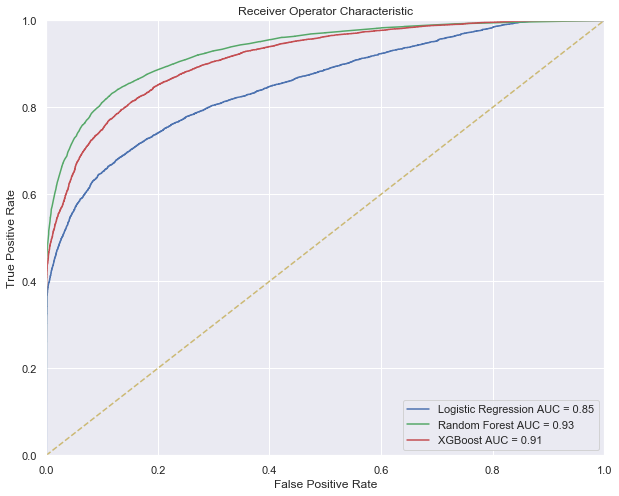

In [35]:
plt.figure(figsize=(10,8))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'Logistic Regression AUC = {}'.format(round(roc_auc1, 2)))
plt.plot(fpr2, tpr2, 'g', label = 'Random Forest AUC = {}'.format(round(roc_auc2, 2)))
plt.plot(fpr3, tpr3, 'r', label = 'XGBoost AUC = {}'.format(round(roc_auc3, 2)))
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'y--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Precision-Recall Curve

Logistic Regression: f1=0.696 auc=0.827
Random Forest: f1=0.813 auc=0.915
XGBoost: f1=0.774 auc=0.890


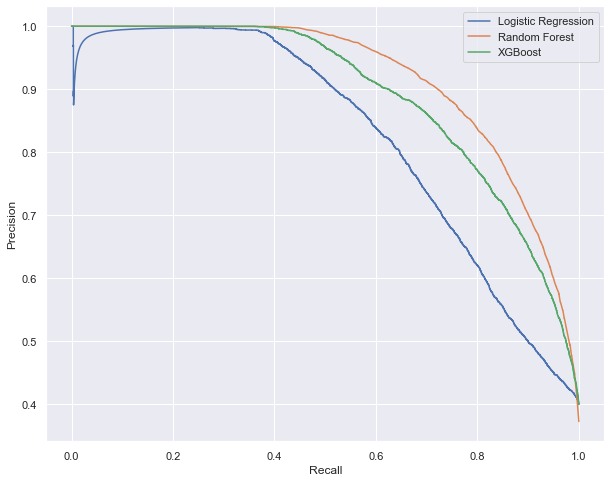

In [36]:
plt.figure(figsize=(10,8))
lr_precision, lr_recall, _ = precision_recall_curve(y_test, pred_prob1[:, 1])
lr_f1, lr_auc = f1_score(y_test, predictions_lr), auc(lr_recall, lr_precision)
rf_precision, rf_recall, _ = precision_recall_curve(y_test, pred_prob2[:, 1])
rf_f1, rf_auc = f1_score(y_test, predictions_rf), auc(rf_recall, rf_precision)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, pred_prob3[:, 1])
xgb_f1, xgb_auc = f1_score(y_test, predictions_xgb), auc(xgb_recall, xgb_precision)
# summarize scores
print('Logistic Regression: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('Random Forest: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))
print('XGBoost: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))
# plot the precision-recall curves
plt.plot(lr_recall, lr_precision, label='Logistic Regression')
plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.plot(xgb_recall, xgb_precision, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Again, the random forest model has the largest area under the curve for both ROC and Precision-Recall curve compared to others . It seems that in this particular case, random forest outperforms the other two models on all metrics.

**Now, can we adjust the probability threshold, for example, to obtain a higher value for precision?**
<br>
Of course we can! We will use the random forest model as an example.

In [37]:
pred_prob2[:,0]

array([1.  , 0.96, 0.  , ..., 0.91, 0.99, 0.  ])

In [38]:
predictions_rf = []
for pred in pred_prob2[:,0]:
    if(pred < 0.2):
        predictions_rf.append(1)
    else:
        predictions_rf.append(0)

In [39]:
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88     14958
           1       0.97      0.57      0.72      8884

    accuracy                           0.83     23842
   macro avg       0.88      0.78      0.80     23842
weighted avg       0.86      0.83      0.82     23842



In [40]:
pd.DataFrame(data=confusion_matrix(y_test, predictions_rf), columns =['P No', 'P Yes'], index = ['A No', 'A Yes'])

,P No,P Yes
A No,14821,137
A Yes,3858,5026


**False Positive Rate** 
<br>
FP / (FP+TN)

In [41]:
(147)/(147 + 14811)

0.009827517047733655

**Specificity**
<br>
TN/(FP+TN) 

In [42]:
(14811)/(147 + 14811)

0.9901724829522663

We obtain a much higher precision score compared to the previous RF model (was 0.87, now is 0.97), and also high specificity and low false positive rate. This indicates that we have lowered the number of False Positive. Just keep in mind that this comes with trade-offs such as a lower recall score. 

We can adjust the threshold to get the best number of a metric that is most useful in a particular case. This metric can be different in other use cases. 

For example, in a disaster prediction system, we may be far more concerned with having low false negatives than low false positives. A false negative would mean not warning about a disaster before it happens, leading to severe consequences or casualties in the public that are unable to take precautions. A false positive means the public would take precautionary measures when they didn’t need to. 
Therefore, domain knowledge is extremely important.